In [1]:
import sys
root_path = '../'
sys.path.insert(0, root_path)

import lightning as L
from natsort import natsorted

from run import *
from utils import *

In [2]:
%load_ext autoreload
%autoreload 2

Load checkpoints

In [3]:
run_name = "3ylpjbd0"
root_dir = os.path.join("../results", "DPT_3", run_name, "checkpoints")

# run_name = "results/DPT_3/3ylpjbd0/checkpoints"
checkpoint = natsorted(os.listdir(root_dir))[-1]
checkpoint_file = os.path.join(root_dir, checkpoint)

model = DPTSolver.load_from_checkpoint(checkpoint_file).cpu()

In [ ]:
checkpoint_file

'../results/DPT_3/3ylpjbd0/checkpoints/epoch=999.ckpt'

Load the offline datasets used for train and validation as well as online dataset with the same problems that were in validation.

In [ ]:
%cd ..

/workspace-SR004.nfs2/kurkin/GreyBoxDPTOptimizer


/home/jovyan/.mlspace/envs/kurkin_exps/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [6]:
config = model.config
config["batch_size"] = 1024
datamodule = ProblemDataModule(config)
datamodule.setup()

train_offline_dataset = datamodule.train_dataloader().dataset
val_offline_dataset = datamodule.val_dataloader().dataset
val_online_dataset = datamodule.test_dataloader().dataset

In [7]:
datamodule.config

{'wandb_params': {'project': 'DPT_3',
  'group': 'QUBO',
  'name': None,
  'entity': None,
  'save_dir': 'results/'},
 'model_params': {'state_dim': 11,
  'action_dim': 11,
  'seq_len': 100,
  'hidden_dim': 128,
  'num_layers': 4,
  'num_heads': 4,
  'attention_dropout': 0.3,
  'residual_dropout': 0.1,
  'embedding_dropout': 0.3},
 'optimizer_params': {'lr': 0.003,
  'weight_decay': 5e-05,
  'eps': 1e-07,
  'betas': [0.9, 0.999]},
 'with_scheduler': True,
 'scheduler_params': {'warmup_epochs': 25},
 'label_smoothing': 0.05,
 'precision': 'bf16-mixed',
 'max_epochs': 1000,
 'log_every_n_steps': 1,
 'seed': 42,
 'do_sample': False,
 'temperature': 1,
 'batch_size': 1024,
 'num_workers': 24,
 'online_steps': 100,
 'problem_params': {'problem': 'QUBO', 'd': 10, 'n': 2, 'n_problems': 150000}}

In [8]:
%cd notebooks/

/workspace-SR004.nfs2/kurkin/GreyBoxDPTOptimizer/notebooks


/home/jovyan/.mlspace/envs/kurkin_exps/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [9]:
def online_inference(model):
    tester = L.Trainer(logger=False, precision=config["precision"])
    test_dataloader = datamodule.test_dataloader()

    # check out two strategies of online inference:
    # - where a predicted action is the argmax of a predicted distribution 
    # - where a predicted action is sampled with temperature = 1 from a predicted distribution 
    hparams = [
        {"do_sample": False, "temperature": 0.0},
        {"do_sample": True, "temperature": 1.0},
    ]
    results_list = []
    for i, hparam in enumerate(hparams):
        model.config["do_sample"] = hparam["do_sample"]
        model.config["temperature"] = hparam["temperature"]
        best_results = tester.test(model=model, dataloaders=test_dataloader)[0]
        best_results = {
            "MAE(best x, x*)": best_results["test x_mae"],
            "MAE(best y, y*)": best_results["test y_mae"]
        }
        all_results = model.save_results
        all_results = {
            "MAE(all x, x*)": all_results["x_mae"].cpu().tolist(),
            "MAE(all y, y*)": all_results["y_mae"].cpu().tolist()
        }
        results_list.append(hparam | best_results | all_results)
    return results_list

In [10]:
results_list = online_inference(model)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using bfloat16 Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

NameError: name 'results_list' is not defined

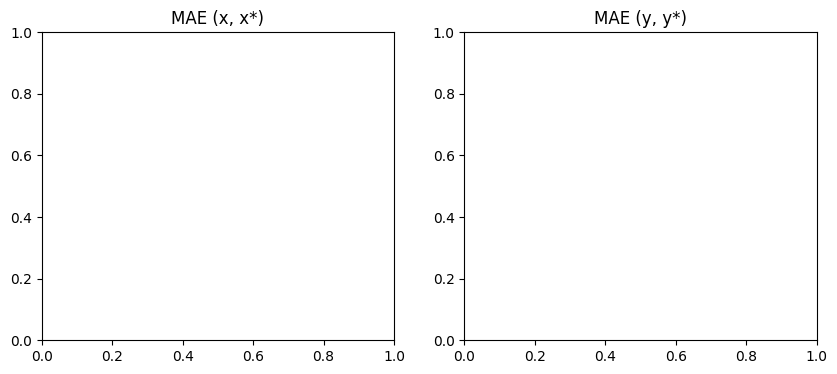

In [24]:
from matplotlib import colormaps as cm

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].set_title('MAE (x, x*)')
axes[1].set_title('MAE (y, y*)')

cmap = cm.get_cmap('jet')
color_list = [cmap(c) for c in np.linspace(0.1, 0.9, len(results_list))[::-1]]
for results, c in zip(results_list, color_list):
    label = f't = {results["temperature"]}' if results["do_sample"] else 'argmax'
    axes[0].plot(results["MAE(all x, x*)"], c=c)
    axes[1].plot(results["MAE(all y, y*)"], c=c, label=f'{label}')
    # print(label)
    # print(f'MAE(best x, x*) = {results["MAE(best x, x*)"]}')
    # print(f'MAE(best y, y*) = {results["MAE(best y, y*)"]}')
    # print()

for ax in axes:
    ax.set_xlim(0, None)
    ax.set_xlabel('Step')
axes[1].set_yscale('log')
axes[1].legend(loc=1)

plt.tight_layout()
plt.show()

An example of offline mode for a problem from the train dataset.

In [9]:
sample, outputs, predictions, metrics = run(model, val_offline_dataset[0])
print_sample(sample, predictions)
print_metrics(metrics)

query_state:
     [0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1.155209]
context:
     {2}
     [0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1.226108] -> 0 -> [1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 6.293175] reward: 2.1487326622009277 {0}
     [0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 8.500586] -> 0 -> [1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 10.727859] reward: 4.029688835144043 {2}
     [0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 8.155829] -> 2 -> [0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 6.003711] reward: 2.1069021224975586 {2}
     [1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 4.449362] -> 2 -> [1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 4.089136] reward: 1.535111904144287 {2}
     [0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 5.786327] -> 6 -> [0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 6.488286] reward: 2.439664840698242 {2}
     [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 14.791676] -> 0 -> [0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 11.566188] reward: 4.3396077156066895 {5}
     [1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 10.514808] -> 5 -> [1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 12.211260] reward: 4.665110111236572 {5}
     [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 11.1

An example of online mode for a problem from the validation dataset.

In [11]:
# one may choose a strategy
# model.config["do_sample"] = False
# model.config["temperature"] = 0.0
model.config["do_sample"] = False
model.config["temperature"] = 1.0

sample, outputs, predictions, metrics = run(model, val_online_dataset[0], n_steps=50)
print_sample(sample, print_ta=True, print_fm=True)
print_metrics(metrics)

query_state:
     [0, 0, 1, 0, 1, 0, 1, 0, 0, 1, -2.002459]
context:
     [0, 0, 1, 0, 1, 0, 1, 0, 0, 1, -2.002459] -> 1 -> [0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0.894225] reward: 0.5
     [0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0.894225] -> 1 -> [0, 0, 1, 0, 1, 0, 1, 0, 0, 1, -2.002459] reward: 1.74797523021698
     [0, 0, 1, 0, 1, 0, 1, 0, 0, 1, -2.002459] -> 7 -> [0, 0, 1, 0, 1, 0, 1, 1, 0, 1, -6.601516] reward: 1.237653136253357
     [0, 0, 1, 0, 1, 0, 1, 1, 0, 1, -6.601516] -> 0 -> [1, 0, 1, 0, 1, 0, 1, 1, 0, 1, -9.386106] reward: 0.3430200517177582
     [1, 0, 1, 0, 1, 0, 1, 1, 0, 1, -9.386106] -> 3 -> [1, 0, 1, 1, 1, 0, 1, 1, 0, 1, -8.854720] reward: 0.35480862855911255
     [1, 0, 1, 1, 1, 0, 1, 1, 0, 1, -8.854720] -> 8 -> [1, 0, 1, 1, 1, 0, 1, 1, 1, 1, -8.372840] reward: 0.39138615131378174
     [1, 0, 1, 1, 1, 0, 1, 1, 1, 1, -8.372840] -> 8 -> [1, 0, 1, 1, 1, 0, 1, 1, 0, 1, -8.854720] reward: 0.5283070802688599
     [1, 0, 1, 1, 1, 0, 1, 1, 0, 1, -8.854720] -> 5 -> [1, 0, 1, 1, 1, 1, 1, 1, 0

In [13]:
outputs.shape

torch.Size([50, 11])

In [ ]:
from tqdm.auto import tqdm

def online_inference_dataset(model, dataset, idx):
    hparams = [
        {"do_sample": False, "temperature": 0.0},
        {"do_sample": True, "temperature": 1.0},
    ]
    results_list = []
    for i, hparam in enumerate(hparams):
        model.config["do_sample"] = hparam["do_sample"]
        model.config["temperature"] = hparam["temperature"]
        all_results = {"x_mae": [], "y_mae": []}
        for i in tqdm(idx):
            with torch.inference_mode():
                _, _, _, metrics = run(model, dataset[i], n_steps=50)
            for k in metrics:
                all_results[k].append(metrics[k].detach().cpu().numpy())
        for k in metrics:
                all_results[k] = np.vstack(all_results[k]).mean(0)
        all_results = {
            "MAE(all x, x*)": all_results["x_mae"],
            "MAE(all y, y*)": all_results["y_mae"]
        }
        results_list.append(hparam | all_results)
    return results_list

[autoreload of src.train failed: Traceback (most recent call last):
  File "/home/jovyan/.mlspace/envs/kurkin_exps/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/jovyan/.mlspace/envs/kurkin_exps/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/home/jovyan/.mlspace/envs/kurkin_exps/lib/python3.12/importlib/__init__.py", line 131, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 995, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1133, in get_code
  File "<frozen importlib._bootstrap_external>", line 1063, in source_to_code
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/workspace-SR004.nfs2/kurkin/GreyBoxDPTOptimizer/noteb

In [31]:
np.vstack(res[0][ 'MAE(all y, y*)']).shape

(10, 50)

In [21]:
res = online_inference_dataset(model, val_online_dataset, list(range(10)))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

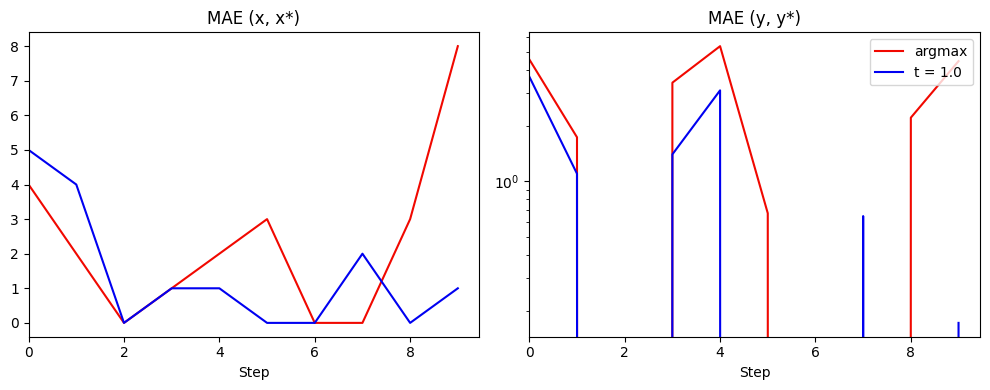

In [32]:
from matplotlib import colormaps as cm

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].set_title('MAE (x, x*)')
axes[1].set_title('MAE (y, y*)')

cmap = cm.get_cmap('jet')
color_list = [cmap(c) for c in np.linspace(0.1, 0.9, len(res))[::-1]]
for results, c in zip(res, color_list):
    label = f't = {results["temperature"]}' if results["do_sample"] else 'argmax'
    axes[0].plot(results["MAE(all x, x*)"], c=c)
    axes[1].plot(results["MAE(all y, y*)"], c=c, label=f'{label}')
    # print(label)
    # print(f'MAE(best x, x*) = {results["MAE(best x, x*)"]}')
    # print(f'MAE(best y, y*) = {results["MAE(best y, y*)"]}')
    # print()

for ax in axes:
    ax.set_xlim(0, None)
    ax.set_xlabel('Step')
axes[1].set_yscale('log')
axes[1].legend(loc=1)

plt.tight_layout()
plt.show()